## Create Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from patsy import dmatrix
from statsmodels.api import GLM, families

def simulate_poisson_process(rate, sampling_frequency):
    return np.random.poisson(rate / sampling_frequency)

def plot_model_vs_true(time, spike_train, firing_rate, conditional_intensity, sampling_frequency):
    fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True, constrained_layout=True)

    s, t = np.nonzero(spike_train)
    axes[0].scatter(np.unique(time)[s], t, s=1, color='black')
    axes[0].set_ylabel('Trials')
    axes[0].set_title('Simulated Spikes')
    axes[0].set_xlim((0, 1))

    axes[1].plot(np.unique(time), firing_rate[:, 0],
                 linestyle='--', color='black',
                 linewidth=4, label='True Rate')
    axes[1].plot(time.ravel(), conditional_intensity * sampling_frequency,
                 linewidth=4, label='model conditional intensity')
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Firing Rate (Hz)')
    axes[1].set_title('True Rate vs. Model')
    axes[1].set_ylim((0, 15))
    plt.legend()

n_time, n_trials = 1500, 1000
sampling_frequency = 1500

# Firing rate starts at 5 Hz and switches to 10 Hz
firing_rate = np.ones((n_time, n_trials)) * 10
firing_rate[:n_time // 2, :] = 5
spike_train = simulate_poisson_process(
    firing_rate, sampling_frequency)
time = (np.arange(0, n_time)[:, np.newaxis] / sampling_frequency *
        np.ones((1, n_trials)))
trial_id = (np.arange(n_trials)[np.newaxis, :]
           * np.ones((n_time, 1)))

## Good Fit

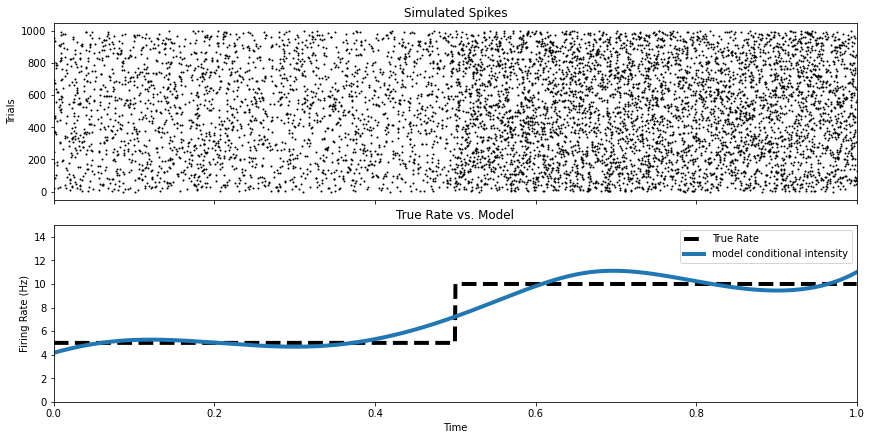

In [2]:
# Fit a spline model to the firing rate
design_matrix = dmatrix('bs(time, df=5)', dict(time=time.ravel()))
fit = GLM(spike_train.ravel(), design_matrix,
          family=families.Poisson()).fit()
conditional_intensity = fit.mu

plot_model_vs_true(time, spike_train, firing_rate, conditional_intensity, sampling_frequency)
plt.savefig('simulated_spikes_model.png')

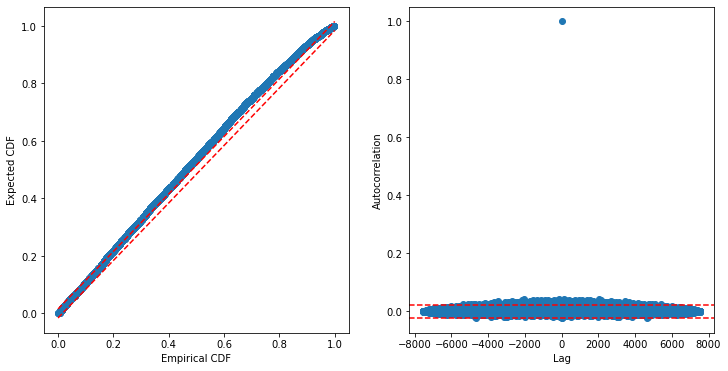

In [3]:
from time_rescale import TimeRescaling

conditional_intensity = fit.mu
rescaled = TimeRescaling(conditional_intensity,
                         spike_train.ravel(),
                         trial_id.ravel())

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
rescaled.plot_ks(ax=axes[0])
rescaled.plot_rescaled_ISI_autocorrelation(ax=axes[1])

plt.savefig('time_rescaling_ks_autocorrelation.png')

### Adjust for short trials

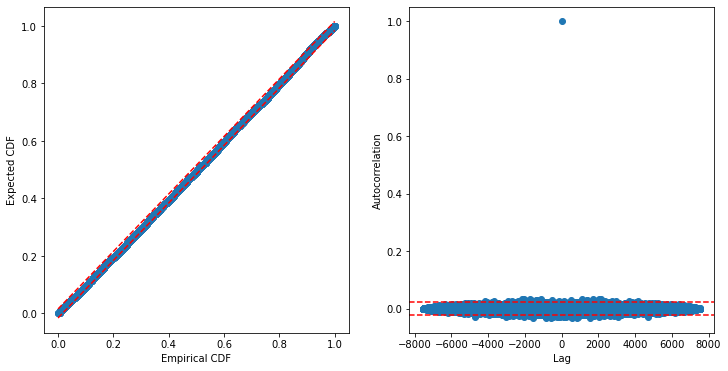

In [4]:
rescaled_adjusted = TimeRescaling(conditional_intensity,
                                  spike_train.ravel(),
                                  trial_id.ravel(),
                                  adjust_for_short_trials=True)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
rescaled_adjusted.plot_ks(ax=axes[0])
rescaled_adjusted.plot_rescaled_ISI_autocorrelation(ax=axes[1])

plt.savefig('time_rescaling_ks_autocorrelation_adjusted.png')

## Bad Fit

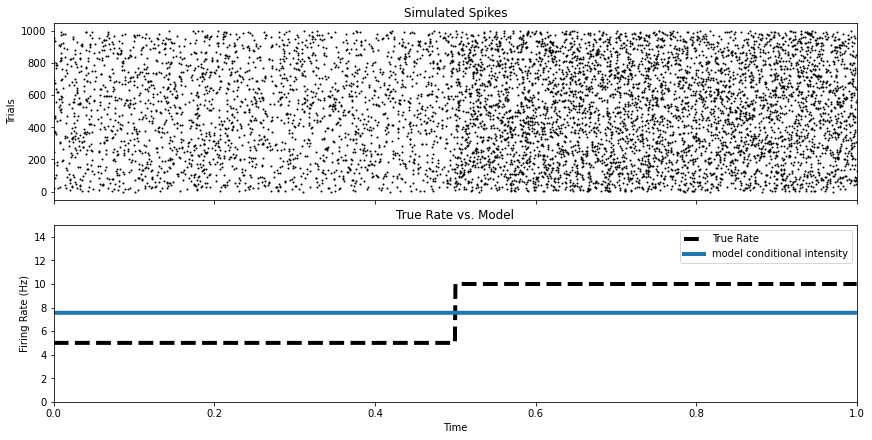

In [5]:
constant_fit = GLM(spike_train.ravel(),
                   np.ones_like(spike_train.ravel()),
                   family=families.Poisson()).fit()

conditional_intensity = constant_fit.mu

plot_model_vs_true(time, spike_train, firing_rate, conditional_intensity, sampling_frequency)
plt.savefig('constant_model_fit.png')

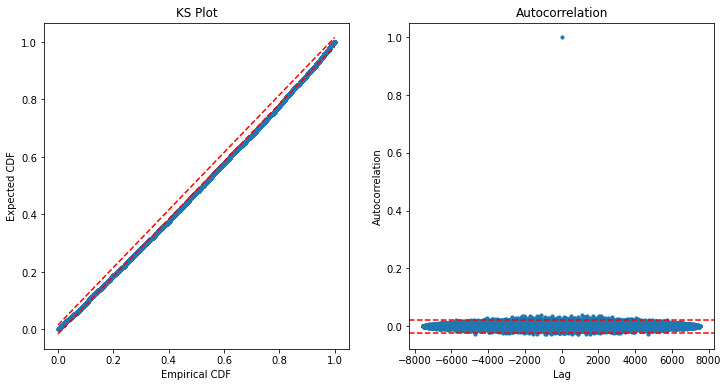

In [6]:
bad_rescaled = TimeRescaling(constant_fit.mu,
                             spike_train.ravel(),
                             trial_id.ravel(),
                             adjust_for_short_trials=True)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
bad_rescaled.plot_ks(ax=axes[0], scatter_kwargs=dict(s=10))
axes[0].set_title('KS Plot')
bad_rescaled.plot_rescaled_ISI_autocorrelation(ax=axes[1], scatter_kwargs=dict(s=10))
axes[1].set_title('Autocorrelation');
plt.savefig('time_rescaling_ks_autocorrelation_bad_fit.png')